# Extracting coastal waterbodies

Three test areas: Port Macquarie, Lake Alexandrina, Shoal Bay. Can we pull out the coastal lakes, rivers, and estuaries?

In [626]:
import datacube
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import xarray as xr
import skimage.measure
import skimage.morphology
import datacube.utils
import matplotlib.cm

import sys
sys.path.insert(1, '../../../Scripts')
from dea_dask import create_local_dask_cluster
from dea_spatialtools import largest_region, xr_vectorize

## Getting started

In [5]:
create_local_dask_cluster()

/env/lib/python3.6/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41367 instead
  http_address["port"], self.http_server.port


Client Scheduler: tcp://127.0.0.1:46291 Dashboard: /user/alger/proxy/41367/status,Cluster Workers: 1 Cores: 8 Memory: 61.42 GB


### Configuration

In [349]:
# Southwest, northeast
port = (-31.73603, 152.67921), (-31.30505, 152.98237)
alexandrina = (-36.34236, 138.55569), (-35.24629, 139.95799)
shoal = (-12.60862, 130.88641), (-12.07365, 131.10413)

In [350]:
port_ylim, port_xlim = zip(*port)
alexandrina_ylim, alexandrina_xlim = zip(*alexandrina)
shoal_ylim, shoal_xlim = zip(*shoal)

### Load em up

In [351]:
dc = datacube.Datacube(app='coastal-extraction')

In [352]:
dask_chunks = {'x': 1000, 'y': 1000, 'time': 1}

In [353]:
da = {
    'port': dc.load('wofs_filtered_summary',
                    x=port_xlim, y=port_ylim,
                    dask_chunks=dask_chunks),
    'alexandrina': dc.load('wofs_filtered_summary',
                            x=alexandrina_xlim, y=alexandrina_ylim,
                            dask_chunks=dask_chunks),
    'shoal': dc.load('wofs_filtered_summary',
                     x=shoal_xlim, y=shoal_ylim,
                     dask_chunks=dask_chunks),
}

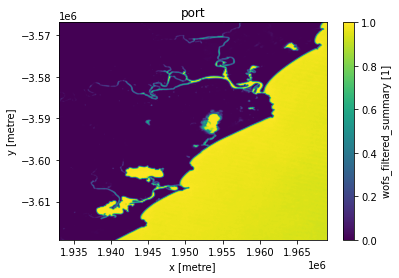

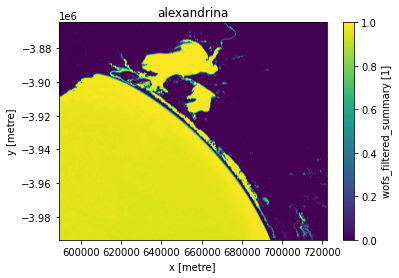

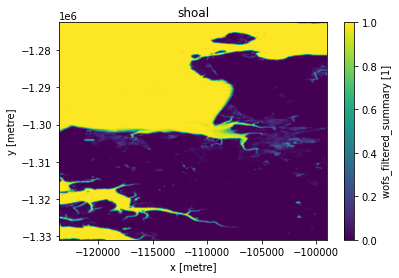

In [354]:
for name, da_ in da.items():
    fig, ax = plt.subplots()
    da_ = da_.wofs_filtered_summary.isel(time=0)
    da_ = da_.where(da_ > -1, 0)
    da_.plot.imshow(ax=ax, interpolation='gaussian')
    ax.set_title(name)

## Find the ocean

Anything with 95% water is water (for sure).

In [355]:
definitely_water = {
    name: largest_region(da_.wofs_filtered_summary.isel(time=0).values > 0.05)
    for name, da_ in da.items()
}

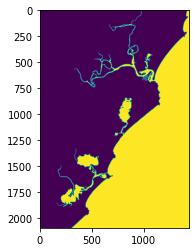

In [356]:
plt.imshow(definitely_water['port'])

Then erode, remove everything except the largest waterbody, and dilate.

In [365]:
disk_dilate = skimage.morphology.disk(9)
disk_erode = skimage.morphology.disk(7)
ocean = {
    name: skimage.morphology.binary_dilation(
        largest_region(
            skimage.morphology.binary_erosion(
                ocean_, disk_erode),
        ),
        disk_dilate)
    for name, ocean_ in definitely_water.items()
}

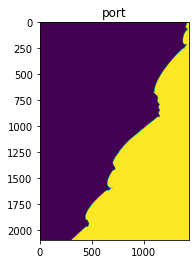

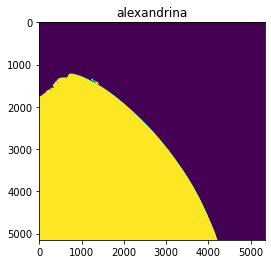

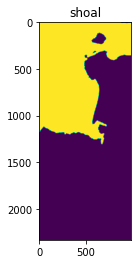

In [366]:
for name, ocean_ in ocean.items():
    plt.title(name)
    plt.imshow(ocean_)
    plt.show()

In [367]:
ocean_mask = {name: xr.DataArray(ocean_,
                                 coords={
                                     'x': da[name].coords['x'],
                                     'y': da[name].coords['y']},
                                 dims=['y', 'x'])
              for name, ocean_ in ocean.items()}

## Find the waterbodies

A waterbody is anything with $\geq$10% wet frequency.

In [444]:
def get_waterbody_mask(da, name, minimum_wetness):
    return (da >= minimum_wetness) & ~ocean_mask[name]

In [445]:
minimum_wetness = 0.1
waterbody_mask = {name: xr.apply_ufunc(get_waterbody_mask, da_.isel(time=0).wofs_filtered_summary, name, minimum_wetness, dask='allowed')
                  for name, da_ in da.items()}

Vectorise this.

In [416]:
waterbodies_minimum = {name: xr_vectorize(mask.values, crs='EPSG:3577', transform=da[name].geobox.transform) for name, mask in waterbody_mask.items()}

/env/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/env/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/env/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/

In [420]:
waterbodies_minimum = {name: w[w.attribute == 1].reset_index(drop=True) for name, w in waterbodies_minimum.items()}

Drop waterbodies with less than 5 Landsat pixels.

In [430]:
waterbodies_minimum = {name: w[w.area >= 5 * 25 ** 2].reset_index(drop=True) for name, w in waterbodies_minimum.items()}

Now find the maximum extent of these by repeating the process with 5% threshold instead and joining.

In [446]:
minimum_wetness_extent = 0.05
waterbody_mask_extent = {name: xr.apply_ufunc(get_waterbody_mask, da_.isel(time=0).wofs_filtered_summary, name, minimum_wetness_extent, dask='allowed')
                         for name, da_ in da.items()}

In [448]:
waterbodies_extent = {name: xr_vectorize(mask.values, crs='EPSG:3577', transform=da[name].geobox.transform) for name, mask in waterbody_mask_extent.items()}

/env/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/env/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/env/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/

In [449]:
waterbodies_extent = {name: w[w.attribute == 1].reset_index(drop=True) for name, w in waterbodies_extent.items()}

In [464]:
waterbodies = {name: gpd.sjoin(waterbodies_extent[name], waterbodies_minimum[name], op='contains', how='left')
               for name in waterbodies_extent}

Then filter out anything without a match.

In [468]:
waterbodies = {name: w[pd.notnull(w.index_right)] for name, w in waterbodies.items()}

In [669]:
waterbodies = {name: w.reset_index().drop_duplicates('index') for name, w in waterbodies.items()}

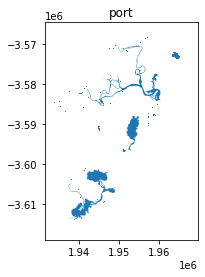

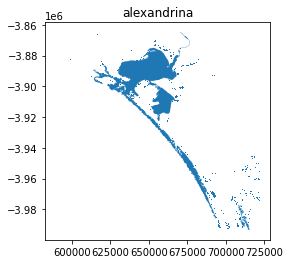

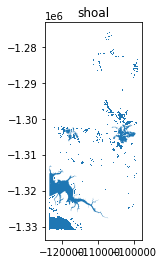

In [670]:
for name, w in waterbodies.items():
    fig, ax = plt.subplots()
    w.plot(ax=ax)
    ax.set_title(name)

### Split up big polygons

Buffer and unbuffer to obtain separated polygons and remove tiny polygons.

In [694]:
buffered = {name: w.buffer(-125).buffer(150) for name, w in waterbodies.items()}

Subtract this from the original.

In [695]:
subtracted = {name: gpd.overlay(waterbodies[name], gpd.GeoDataFrame(geometry=[buffered[name].unary_union], crs='EPSG:3577'), how='difference')
              for name in buffered}

Pull out all the separate subtracted polygons.

In [697]:
subtracted_polygons = {}
for name in subtracted:
    subtracted_polygons[name] = []
    for p in subtracted[name].geometry:
        try:  # Multipolygon
            subtracted_polygons[name].extend(p)
        except TypeError:  # Polygon
            subtracted_polygons[name].append(p)
    subtracted_polygons[name] = gpd.GeoDataFrame(geometry=subtracted_polygons[name], crs='EPSG:3577')

In [699]:
subtracted_polygons = {name: subtracted_polygons[name][subtracted_polygons[name].area >= 5 * 25 ** 2] for name in subtracted_polygons}

Then remove _these_ polygons and see what's left.

In [700]:
resubtracted = {name: gpd.overlay(waterbodies[name], subtracted_polygons[name], how='difference') for name in waterbodies}

In [701]:
resubtracted_polygons = {}
for name in waterbodies:
    resubtracted_polygons[name] = []
    for p in resubtracted[name].geometry:
        try:  # Multipolygon
            resubtracted_polygons[name].extend(p)
        except TypeError:  # Polygon
            resubtracted_polygons[name].append(p)
    resubtracted_polygons[name] = gpd.GeoDataFrame(geometry=resubtracted_polygons[name], crs='EPSG:3577')

There are little bits that should be attached but aren't. Find all small polygons attached to these big new polygons. For each big new polygon, search for touching polygons and squish them together.

In [702]:
new_big_geometry = {}
for name in waterbodies:
    new_big_geometry[name] = []
    unassigned = np.ones(len(subtracted_polygons[name]), dtype=bool)
    for i, big in resubtracted_polygons[name].iterrows():
        mask = subtracted_polygons[name].exterior.intersects(big.geometry.exterior) & unassigned
        neighbours = subtracted_polygons[name][mask]
        unassigned[mask] = 0
        big = big.geometry.union(neighbours.unary_union)
        new_big_geometry[name].append(big)

In [704]:
big_geometry = {name: gpd.GeoDataFrame(geometry=nbg) for name, nbg in new_big_geometry.items()}

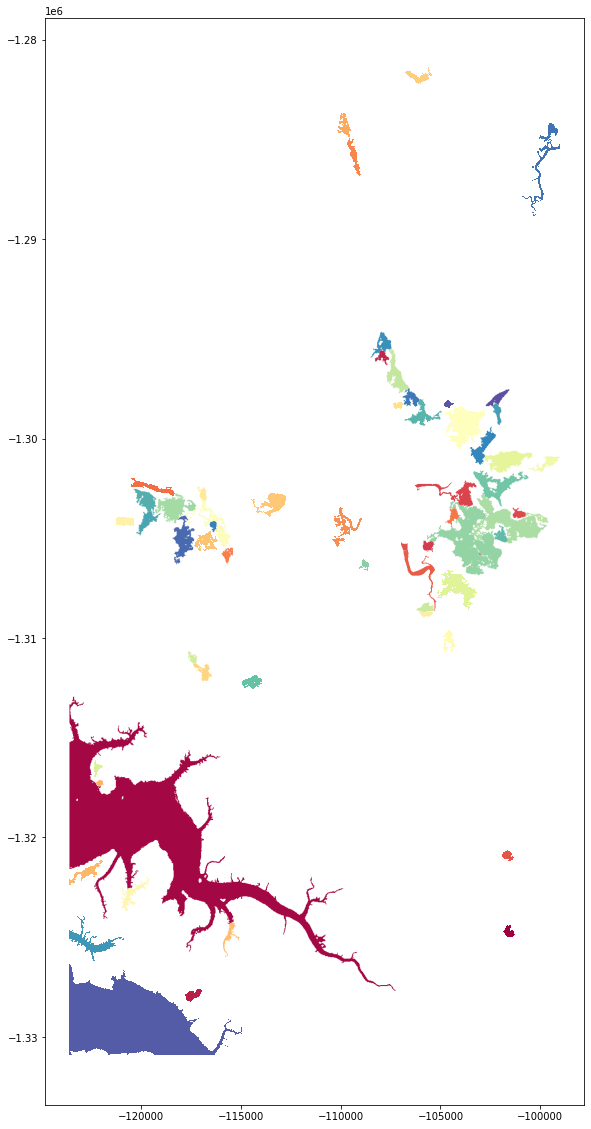

In [707]:
fig, ax = plt.subplots(figsize=(20, 20))
colours = matplotlib.cm.Spectral(np.linspace(0, 1, len(big_geometry['shoal'])))
np.random.shuffle(colours)
big_geometry['shoal'].plot(color=colours, ax=ax)